In [1]:
!pip install cmsisdsp

  Obtaining dependency information for cmsisdsp from https://files.pythonhosted.org/packages/70/03/f4fe2acec947350b68cbc95f08b5c0ef507ac1f839092c93f2c46d507da0/cmsisdsp-1.9.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for numpy<1.23,>=1.22 from https://files.pythonhosted.org/packages/b0/f4/d67c8c39efe3c45dfd32bb2a3fc49cbbe5496e575cc42b8bac60fe7b6701/numpy-1.22.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 12.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 require

In [2]:
import pickle
import librosa
import pathlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from os.path import join
from numpy import pi as PI
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.models import Sequential
from sklearn.metrics import r2_score
from tensorflow.saved_model import save
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, LSTM, Reshape
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from cmsisdsp import arm_float_to_q15, arm_mult_q15, arm_rfft_q15
from cmsisdsp import arm_cmplx_mag_q15, arm_rfft_instance_q15,arm_cos_f32, arm_rfft_init_q15

In [3]:
DATA_PATH = "/kaggle/input/rain-seq-master"
BASIC_DATA_PATH = join(DATA_PATH, "data_basic.csv")
model_name = "seq_stft.weights.h5"

Fs = 8000
LEARNING_RATE = 0.001
WINDOW_SIZE = 512
STEP_SIZE = 256
SEQ_LEN = 8000

In [4]:
!mkdir saved_TF_model
!mkdir model

In [5]:
def find_zero_point_percentage(df):
    df_non_zero = df[df["target"] != 0]
    df_zero = df[df["target"] == 0]
    T = df.shape[0]
    non_zeros = df_non_zero.shape[0]
    zeros = df_zero.shape[0]
    print("Percentage of Zero datapoints: ", zeros * 100 / T, "%")

In [6]:
basic_data = pd.read_csv(BASIC_DATA_PATH)
basic_data = basic_data[basic_data["target"] != 0.4]
basic_data = basic_data[["checkpoint", "fname", "target"]]
basic_data["checkpoint"] = pd.to_datetime(basic_data["checkpoint"])

In [7]:
find_zero_point_percentage(basic_data)

Percentage of Zero datapoints:  68.14814814814815 %


In [8]:
basic_data["target"].value_counts()

target
0.0    184
0.2     86
Name: count, dtype: int64

In [9]:
basic_data_non_zero = basic_data[basic_data["target"] != 0]
basic_data_zero = basic_data[basic_data["target"] == 0]
basic_data_zero = basic_data_zero.sample(n=90)
basic_data_merged = pd.concat([basic_data_non_zero, basic_data_zero], ignore_index=True)
basic_data = basic_data_merged.sample(frac=1)
basic_data.sort_values(by="checkpoint")

,checkpoint,fname,target
115,2024-04-11 22:20:59.757439,audio_0.npy,0.0
129,2024-04-11 22:21:09.757439,audio_1.npy,0.0
157,2024-04-11 22:21:19.757438,audio_2.npy,0.0
117,2024-04-11 22:21:39.757440,audio_4.npy,0.0
0,2024-04-11 22:21:49.757439,audio_5.npy,0.2
...,...,...,...
142,2024-04-14 06:01:29.757440,audio_272.npy,0.0
85,2024-04-14 06:01:59.757438,audio_275.npy,0.2
107,2024-04-15 06:00:29.757440,audio_283.npy,0.0
172,2024-04-15 06:00:49.757439,audio_285.npy,0.0


In [10]:
find_zero_point_percentage(basic_data)

Percentage of Zero datapoints:  51.13636363636363 %


In [11]:
basic_data["target"].value_counts().keys()

Index([0.0, 0.2], dtype='float64', name='target')

### Classification of rainfall events and respective rainfallintensity ranges as defined by India Meteorological Department (IMD)
- 0.1 - 2.4 Very Light Rain (VLR)
- 2.5 - 7.5 Light Rain (LR)
- 7.6 - 35.5 Moderate Rain (MR)
- 35.6 - 64.4 Rather Heavy Rain (RHR)
- 64.5 - 124.4 Heavy Rain (HR)
- 124.5 - 244.4 Very Heavy Rain (VHR)
- greater than 244.5 Extremly Heavy Rain

In [12]:
find_zero_point_percentage(basic_data)

Percentage of Zero datapoints:  51.13636363636363 %


In [13]:
hanning_window_f32 = np.zeros(WINDOW_SIZE)
for i in range(WINDOW_SIZE):
    hanning_window_f32[i] = 0.5 * (1 - arm_cos_f32(2 * PI * i / WINDOW_SIZE))
hanning_window_q15 = arm_float_to_q15(hanning_window_f32)
rfft_instance_q15 = arm_rfft_instance_q15()
status = arm_rfft_init_q15(rfft_instance_q15, WINDOW_SIZE, 0, 1)

In [14]:
class Dataset:
    def __init__(self, basic_data, data_path, output_shape, validation=False):
        self.basic_data = basic_data
        self.y = self.basic_data["target"].values
        self.X = self.basic_data["fname"].values
        self.data_path = data_path
        self.validation = validation
        self.output_shape = output_shape
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.25
        )
        
    def compute_fft_CMSIS(self, audio_samples, window_size=WINDOW_SIZE, step_size=STEP_SIZE):
        audio_samples_q15 = arm_float_to_q15(audio_samples)
        number_of_windows = int(1 + (SEQ_LEN - window_size) // step_size)
        fft_size = int(window_size // 2 + 1)
        spectrogram_q15 = np.empty((fft_size,))
        start_index = 0

        for index in range(number_of_windows):
            audio_window_q15 = audio_samples_q15[start_index : start_index + window_size]
            processed_audio_q15 = arm_mult_q15(audio_window_q15, hanning_window_q15)
            rfft_q15 = arm_rfft_q15(rfft_instance_q15, processed_audio_q15)
            rfft_mag_q15 = arm_cmplx_mag_q15(rfft_q15)[:fft_size]
            spectrogram_q15 = rfft_mag_q15
            start_index += step_size
        return spectrogram_q15

    def compute_stft_CMSIS(self, audio_samples, window_size=WINDOW_SIZE, step_size=STEP_SIZE):
        audio_samples_q15 = arm_float_to_q15(audio_samples)
        number_of_windows = int(1 + (SEQ_LEN - window_size) // step_size)
        fft_size = int(window_size // 2 + 1)
        spectrogram_q15 = np.empty((number_of_windows, fft_size))
        start_index = 0

        for index in range(number_of_windows):
            audio_window_q15 = audio_samples_q15[start_index : start_index + window_size]
            processed_audio_q15 = arm_mult_q15(audio_window_q15, hanning_window_q15)
            rfft_q15 = arm_rfft_q15(rfft_instance_q15, processed_audio_q15)
            rfft_mag_q15 = arm_cmplx_mag_q15(rfft_q15)[:fft_size]
            spectrogram_q15[index] = rfft_mag_q15
            start_index += step_size
        return spectrogram_q15

    def __len__(self):
        if self.validation:
            data_len = int(np.ceil(len(self.y_test)))
        else:
            data_len = int(np.ceil(len(self.y_train)))
        return int(np.ceil(data_len))

    def create_cnn_data(self, raw_data):
        Zxx = librosa.stft(raw_data)
        stft_sample = np.abs(Zxx)
        return stft_sample

    def create_mfcc_data(self, raw_data):
        mfcc = librosa.feature.mfcc(y=raw_data, sr=Fs, n_mfcc=13)
        return mfcc

    def create_chroma_stft_data(self, raw_data):
        chroma = librosa.feature.chroma_stft(y=raw_data, sr=Fs)
        return chroma

    def __getitem__(self, index):
        if self.validation:
            audio_file = self.X_test[index]
            batch_target = self.y_test[index]
        else:
            audio_file = self.X_train[index]
            batch_target = self.y_train[index]

        audio_data = np.load(join(self.data_path, audio_file))
        audio_data = audio_data[:SEQ_LEN]
        features = self.compute_fft_CMSIS(audio_data)
#         print(features.shape)

        batch_target = batch_target.reshape(self.output_shape)

        return features, batch_target

In [15]:
class Dataloder(Sequence):
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []

        for j in range(start, stop):
            data.append(self.dataset[j])
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [16]:
EPOCHS = 20
BATCH_SIZE = 1
output_shape = (1, 1)

In [17]:
train_dataset = Dataset(basic_data,
                        DATA_PATH,
                        output_shape)

train_dataloader = Dataloder(train_dataset, 
                             batch_size=BATCH_SIZE)

test_dataset = Dataset(basic_data,
                       DATA_PATH,
                       output_shape,
                       validation=True)

test_dataloader = Dataloder(test_dataset, 
                            batch_size=BATCH_SIZE)

In [18]:
adamopt = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [19]:
def create_functional_model():
    model = Sequential()
    model.add(Dense(4, input_shape=(257, )))
#     model.add(Conv2D(1, kernel_size=(2, 2), activation='relu', input_shape=(28, 513, 1)))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(6, kernel_size=(2, 2), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Reshape((1, -1)))
#     model.add(LSTM(5))
#     model.add(Dense(2))
    model.add(Dense(1))
    return model

In [20]:
model = create_functional_model()

In [21]:
cp_callback = ModelCheckpoint(filepath=model_name,
                              monitor="val_loss",
                              verbose=0,
                              save_best_only=True,
                              save_weights_only=True,
                              mode="min")

In [22]:
model.compile(optimizer=adamopt, loss="mean_squared_error", metrics=["mse"])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 1032      
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1037 (4.05 KB)
Trainable params: 1037 (4.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
history = model.fit(train_dataloader,
                    validation_data=test_dataloader,
                    epochs=EPOCHS,
                    callbacks=[cp_callback])

Epoch 1/20
132/132 [==============================] - 3s 20ms/step - loss: 3.9939 - mse: 3.9939 - val_loss: 2.2636 - val_mse: 2.2636
Epoch 2/20
132/132 [==============================] - 1s 8ms/step - loss: 1.5664 - mse: 1.5664 - val_loss: 1.4952 - val_mse: 1.4952
Epoch 3/20
132/132 [==============================] - 1s 7ms/step - loss: 0.8812 - mse: 0.8812 - val_loss: 1.8164 - val_mse: 1.8164
Epoch 4/20
132/132 [==============================] - 1s 7ms/step - loss: 0.7246 - mse: 0.7246 - val_loss: 0.7875 - val_mse: 0.7875
Epoch 5/20
132/132 [==============================] - 1s 7ms/step - loss: 0.4550 - mse: 0.4550 - val_loss: 0.6397 - val_mse: 0.6397
Epoch 6/20
132/132 [==============================] - 1s 7ms/step - loss: 0.3827 - mse: 0.3827 - val_loss: 0.6480 - val_mse: 0.6480
Epoch 7/20
132/132 [==============================] - 1s 7ms/step - loss: 0.2658 - mse: 0.2658 - val_loss: 0.4487 - val_mse: 0.4487
Epoch 8/20
132/132 [==============================] - 1s 6ms/step - loss: 0

In [25]:
with open("history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [26]:
def plot_history(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("log Loss")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()

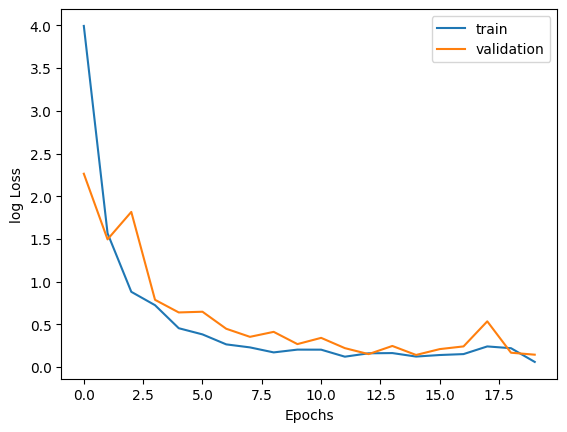

In [27]:
plot_history(history)

In [28]:
export_dir = "saved_TF_model"
save(model, export_dir)

In [29]:
model.load_weights(model_name)

In [30]:
y_preds = []
y_tests = []
n_test = test_dataloader.__len__()
for i in tqdm(range(n_test)):
    X_test, y_test = test_dataloader.__getitem__(i)
    y_tests.append(y_test[0][0][0])
    y_pred = model.predict(X_test, verbose=0)[0][0]
    y_preds.append(y_pred)
result_df = pd.DataFrame()
result_df["y_tests"] = y_tests
result_df["y_preds"] = y_preds

100%|██████████| 44/44 [00:02<00:00, 14.94it/s]


Text(0, 0.5, 'Rainfall acoustic (mm) (estimated)')

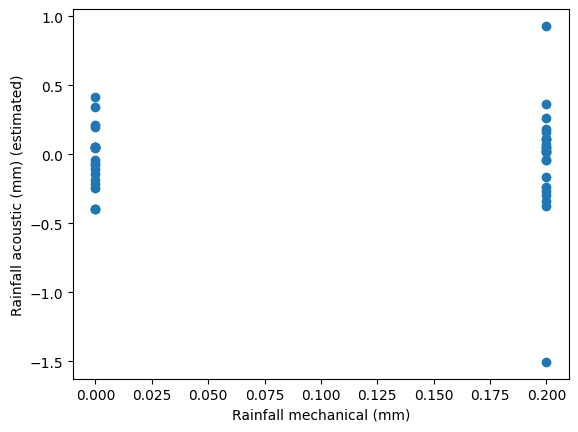

In [31]:
plt.scatter(result_df["y_tests"], result_df["y_preds"])
plt.xlabel("Rainfall mechanical (mm)")
plt.ylabel("Rainfall acoustic (mm) (estimated)")

In [32]:
result_df

,y_tests,y_preds
0,0.0,-0.398816
1,0.2,-0.042005
2,0.0,0.200900
3,0.2,0.160282
4,0.0,0.052275
5,0.0,-0.211361
6,0.2,-1.503297
7,0.0,0.345216
8,0.0,-0.062250
9,0.0,-0.398437


In [33]:
result = result_df[(result_df["y_tests"]!=0.0)]
A = result["y_tests"]
F = result["y_preds"]
N = result.shape[0]
MAPE = np.sum(abs((A-F)/(A+0.00001)))*100/N
print("Mean Absolute Percentage Error: {}%".format(np.round(MAPE, 3)))

Mean Absolute Percentage Error: 155.405%


In [34]:
result_df.corr(method='spearman')

,y_tests,y_preds
y_tests,1.000000,0.100768
y_preds,0.100768,1.000000


In [35]:
print("R2 score: ", r2_score(result_df["y_tests"], result_df["y_preds"]))

R2 score:  -13.30583905715366


In [36]:
result_df.to_csv("result_df.csv")

In [37]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path("./model/model.tflite")
model_size_kb = tflite_model_file.write_bytes(tflite_model) / 1024
print("Size of TensorFlow Lite Model: {} KB:".format(model_size_kb))

Size of TensorFlow Lite Model: 5.3359375 KB:


In [38]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_tensor = interpreter.get_input_details()[0]['index']
output_tensor = interpreter.get_output_details()[0]['index']

test_input = tf.random.uniform([1, 28, 513, 1], dtype=tf.float32)
interpreter.invoke()

output_data = interpreter.get_tensor(output_tensor)[0][0]
print("Prediction on random test input: ", output_data)

Prediction on random test input:  nan


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Generate a TensorFlow Lite for Microcontrollers Model

In [39]:
!apt-get update && apt-get -qq install xxd

Get:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]
Get:2 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [627 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [3592 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [29.8 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [3536 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1199 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [3686 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal

In [40]:
MODEL_TFLITE = "./model/model.tflite" 
MODEL_TFLITE_MICRO = "./model/model.cc" 
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}